__This is is my capstone project to apply knowledge in Data Science.__  

_Yahoo!_

In [1]:
import pandas as pd
import numpy as np

In [2]:
print("Hello Capstone Project Course!")

Hello Capstone Project Course!


Part 1
=======

Skrap Wikipedia to get dataframe about neighbours in Toronto

In [3]:
import bs4
import re
from bs4 import BeautifulSoup # this module helps in web scrapping.
import requests  # this module helps us to download a web page

In [4]:
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'
html = requests.get(url).text

In [41]:
soup = BeautifulSoup(html)

def parse_td(td):
    # Each cell in table contains two visible lines of data
    code=''
    info=''
    for i in td.p:
        if getattr(i, 'name', None) != 'br' and isinstance(i, bs4.element.Tag):
            if code=='':
                code = i.text
            else:
                info = i.text
                return (code, info)
    return None 

def make_rows(pr):
    #Available formats in cell
    #Option 1 - skip this cell
    #CODE
    #Not Assigned
    #Option 2 - can contains many rows for data frame
    #CODE
    #list of Borough[(List/Of/Neighbours)],...
    code = pr[0]
    info = pr[1]
    
    result = []
    if info == 'Not assigned':
        return result
    
    for x1 in info.split(')'):
        if x1 == '' or x1.isspace():
            break
        l1 = x1.split('(')
        bor = l1[0].strip()
        if len(l1) == 1:
            nei = bor
        else:
            nei = l1[1].strip().replace('/', ',')
        result.append({"Postal Code": code, "Borough": bor, "Neighborhood": nei})
        
    return result

data = pd.DataFrame(columns=["Postal Code", "Borough", "Neighborhood"])
for td in soup.find('table').find_all('td'):
    pr = parse_td(td)
    for r in make_rows(pr):
        data = data.append(r, ignore_index=True)

data.shape

(111, 3)

In [44]:
#Check that no missed data
data[data.isna().any(axis=1)]

,Postal Code,Borough,Neighborhood


In [45]:
# List of duplicates
data[data['Postal Code'].duplicated(keep=False)]

,Postal Code,Borough,Neighborhood
7,M3B,North York,Don Mills
8,M3B,North,North
14,M3C,North York,Don Mills
15,M3C,South,Flemingdon Park
42,M3K,North York,Downsview
43,M3K,East,CFB Toronto
49,M3L,North York,Downsview
50,M3L,West,West
57,M3M,North York,Downsview
58,M3M,Central,Central


Part 2
========

Get lattitude longitude of neighbours

In [18]:
#Couldn't use geocoder
#import geocoder # import geocoder
#def geocoder_helper(postal_code):
#     # initialize your variable to None
#    lat_lng_coords = None
#    
#    # loop until you get the coordinates
#    while(lat_lng_coords is None):
#        g = geocoder.google('{}, Toronto, Ontario'.format(postal_code))
#        lat_lng_coords = g.latlng
#    
#     return lat_lng_coords

gsd_df = pd.read_csv("./Geospatial_Coordinates.csv")
gsd_df.set_index('Postal Code', inplace=True)
gsd_df.head()

,Latitude,Longitude
Postal Code,,
M1B,43.806686,-79.194353
M1C,43.784535,-79.160497
M1E,43.763573,-79.188711
M1G,43.770992,-79.216917
M1H,43.773136,-79.239476


In [46]:
new_data = pd.merge(data, gsd_df, left_on='Postal Code', right_index=True)
new_data.shape

(111, 5)

Part 3
=========

Cluster Borough

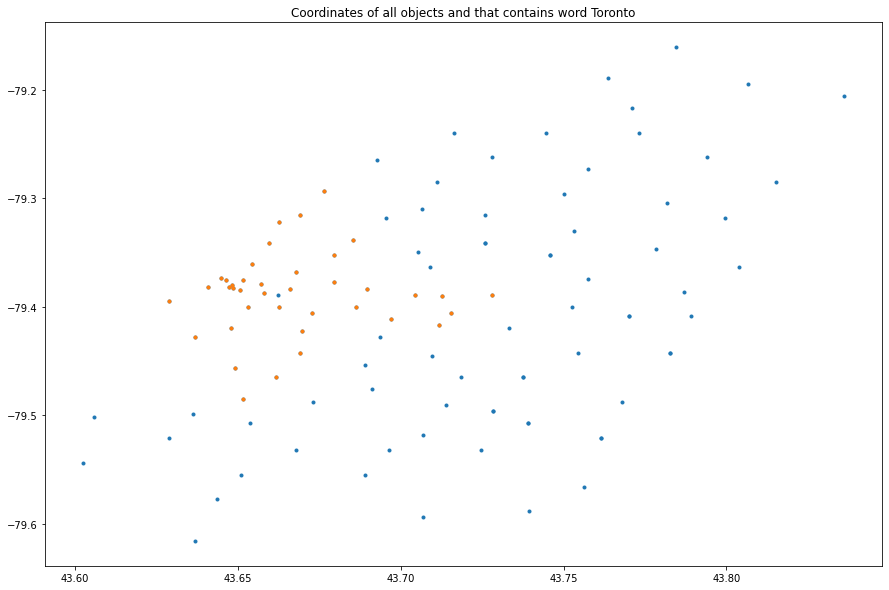

In [60]:
import matplotlib.pyplot as plt # plotting library
%matplotlib inline 
tor_data = new_data[['Toronto' in x for x in new_data['Borough']]]
plt.figure(figsize=(15, 10))
plt.title('Coordinates of all objects and that contains word Toronto')
plt.scatter(new_data['Latitude'], new_data['Longitude'], marker='.')
plt.scatter(tor_data['Latitude'], tor_data['Longitude'], marker='.')

In [78]:
import folium
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

address = 'Toronto'

geolocator = Nominatim(user_agent='foursquare_agent')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in tor_data[['Latitude', 'Longitude', 'Borough', 'Neighborhood']].values:
    label = f'{borough}: {neighborhood}'
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='blue',
        fill_opacity=0.7).add_to(map_toronto)  
    
map_toronto 

In [125]:
# Use foursquare API 
# define Foursquare Credentials and Version
CLIENT_ID = 'your Foursquare ID' # your Foursquare ID
CLIENT_SECRET = 'your Foursquare Secret' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

from config import CLIENT_ID, CLIENT_SECRET, ACCESS_TOKEN
VERSION = '20180604'
LIMIT = 30

Your credentails:
CLIENT_ID: your Foursquare ID
CLIENT_SECRET:your Foursquare Secret


In [151]:
url='https://api.foursquare.com/v2/venues/categories?client_id={}&client_secret={}&v={}'.format(CLIENT_ID, CLIENT_SECRET, VERSION)
cat_reply = requests.get(url).json()

In [223]:
from flatten_json import flatten
dict_flattened = (flatten(record, '.') for record in cat_reply['response']['categories'])
df = pd.DataFrame(dict_flattened)
clcl = [x for x in df.columns if 'name' in x]
df = df[clcl]
cat_group = {}
for x in df[clcl].values:
    cat_group[x[0]] = [y for y in x if type(y) == str]

#cat_group
def group_category(detailed):
    for key in cat_group:
        if detailed in cat_group[key]:
            return key
            
    return 'NONE'

group_category('Bakery')

'Food'

In [224]:
radius = 500
LIMIT = 100

venues = []
for lat, lng, code, borough, neighborhood in tor_data[['Latitude', 'Longitude', 'Postal Code', 'Borough', 'Neighborhood']].values:

    url = "https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}".format(
        CLIENT_ID,
        CLIENT_SECRET,
        VERSION,
        lat,
        lng,
        radius, 
        LIMIT)
    
    reply = requests.get(url).json()
    results = reply["response"]['groups'][0]['items']
    
    for venue in results:
        venues.append((
            code, 
            borough,
            neighborhood,
            lat, 
            lng, 
            venue['venue']['name'], 
            venue['venue']['location']['lat'], 
            venue['venue']['location']['lng'],  
            group_category(venue['venue']['categories'][0]['name'])))

In [225]:
venues_df = pd.DataFrame(venues)

# define the column names
venues_df.columns = ['Postal Code', 'Borough', 'Neighborhood', 'BoroughLatitude', 'BoroughLongitude', 'VenueName', 'VenueLatitude', 'VenueLongitude', 'VenueCategory']

print(venues_df.shape)
venues_df.head()

(1579, 9)


,Postal Code,Borough,Neighborhood,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Tandem Coffee,43.653559,-79.361809,Food
1,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Roselle Desserts,43.653447,-79.362017,Food
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Cooper Koo Family YMCA,43.653249,-79.358008,Professional & Other Places
3,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Impact Kitchen,43.656369,-79.356980,Food
4,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.65426,-79.360636,Body Blitz Spa East,43.654735,-79.359874,Shop & Service


In [226]:
venues_df.groupby(["Postal Code", "Borough", "Neighborhood"]).count()

,,,BoroughLatitude,BoroughLongitude,VenueName,VenueLatitude,VenueLongitude,VenueCategory
Postal Code,Borough,Neighborhood,,,,,,
M4E,East Toronto,The Beaches,4,4,4,4,4,4
M4J,East YorkEast Toronto,The Danforth East,4,4,4,4,4,4
M4K,East Toronto,"The Danforth West , Riverdale",42,42,42,42,42,42
M4L,East Toronto,"India Bazaar , The Beaches West",21,21,21,21,21,21
M4M,East Toronto,Studio District,36,36,36,36,36,36
M4N,Central Toronto,Lawrence Park,4,4,4,4,4,4
M4P,Central Toronto,Davisville North,6,6,6,6,6,6
M4R,Central Toronto,North Toronto West,19,19,19,19,19,19
M4S,Central Toronto,Davisville,33,33,33,33,33,33


In [241]:
# one hot encoding
ext_tor_df = pd.get_dummies(venues_df[['VenueCategory']], prefix="", prefix_sep="")

# add postal, borough and neighborhood column back to dataframe
ext_tor_df['Postal Code']   = venues_df['Postal Code'] 
ext_tor_df['Borough']       = venues_df['Borough'] 
ext_tor_df['Neighborhoods'] = venues_df['Neighborhood'] 

# move postal, borough and neighborhood column to the first column
fixed_columns = list(ext_tor_df.columns[-3:]) + list(ext_tor_df.columns[:-3])

fixed_columns.remove('Food')
fixed_columns.remove('Shop & Service')

ext_tor_df = ext_tor_df[fixed_columns]

print(ext_tor_df.shape)
ext_tor_df.head()

(1579, 9)


,Postal Code,Borough,Neighborhoods,Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Travel & Transport
0,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0
1,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,1,0
3,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0
4,M5A,Downtown Toronto,"Regent Park , Harbourfront",0,0,0,0,0,0


In [242]:
tor_grouped_df = ext_tor_df.groupby(["Postal Code", "Borough", "Neighborhoods"]).mean().reset_index()

print(tor_grouped_df.shape)
tor_grouped_df

(39, 9)


,Postal Code,Borough,Neighborhoods,Arts & Entertainment,College & University,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Travel & Transport
0,M4E,East Toronto,The Beaches,0.000000,0.000000,0.250000,0.500000,0.000000,0.000000
1,M4J,East YorkEast Toronto,The Danforth East,0.000000,0.000000,0.000000,0.250000,0.000000,0.250000
2,M4K,East Toronto,"The Danforth West , Riverdale",0.000000,0.000000,0.071429,0.047619,0.000000,0.000000
3,M4L,East Toronto,"India Bazaar , The Beaches West",0.047619,0.000000,0.095238,0.142857,0.000000,0.000000
4,M4M,East Toronto,Studio District,0.000000,0.000000,0.111111,0.111111,0.027778,0.000000
5,M4N,Central Toronto,Lawrence Park,0.000000,0.000000,0.000000,0.250000,0.250000,0.250000
6,M4P,Central Toronto,Davisville North,0.000000,0.000000,0.000000,0.166667,0.000000,0.166667
7,M4R,Central Toronto,North Toronto West,0.000000,0.000000,0.000000,0.157895,0.000000,0.052632
8,M4S,Central Toronto,Davisville,0.000000,0.000000,0.030303,0.090909,0.000000,0.000000
9,M4T,Central Toronto,"Moore Park , Summerhill East",0.000000,0.000000,0.000000,1.000000,0.000000,0.000000


In [244]:
num_top_venues = 6

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
areaColumns = ['Postal Code', 'Borough', 'Neighborhoods']
freqColumns = []
for ind in np.arange(num_top_venues):
    try:
        freqColumns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        freqColumns.append('{}th Most Common Venue'.format(ind+1))
columns = areaColumns+freqColumns

# create a new dataframe
top_venues_df = pd.DataFrame(columns=columns)
top_venues_df['Postal Code']   = tor_grouped_df['Postal Code']
top_venues_df['Borough']       = tor_grouped_df['Borough']
top_venues_df['Neighborhoods'] = tor_grouped_df['Neighborhoods']

for ind in np.arange(tor_grouped_df.shape[0]):
    row_categories = tor_grouped_df.iloc[ind, :].iloc[3:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    top_venues_df.iloc[ind, 3:] = row_categories_sorted.index.values[0:num_top_venues]

# neighborhoods_venues_sorted.sort_values(freqColumns, inplace=True)
print(top_venues_df.shape)
top_venues_df

(39, 9)


,Postal Code,Borough,Neighborhoods,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
0,M4E,East Toronto,The Beaches,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
1,M4J,East YorkEast Toronto,The Danforth East,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places
2,M4K,East Toronto,"The Danforth West , Riverdale",Nightlife Spot,Outdoors & Recreation,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
3,M4L,East Toronto,"India Bazaar , The Beaches West",Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
4,M4M,East Toronto,Studio District,Nightlife Spot,Outdoors & Recreation,Professional & Other Places,Arts & Entertainment,College & University,Travel & Transport
5,M4N,Central Toronto,Lawrence Park,Outdoors & Recreation,Professional & Other Places,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot
6,M4P,Central Toronto,Davisville North,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places
7,M4R,Central Toronto,North Toronto West,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places
8,M4S,Central Toronto,Davisville,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
9,M4T,Central Toronto,"Moore Park , Summerhill East",Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport


**Clusterization**

In [264]:
from sklearn.cluster import KMeans 
from sklearn.datasets import make_blobs
# set number of clusters
kclusters = 5

tor_clust_df = tor_grouped_df.drop(["Postal Code", "Borough", "Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0, algorithm='elkan').fit(tor_clust_df)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:5] 

array([3, 2, 0, 0, 0])

In [265]:
# create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.
tor_merged_df = tor_data.copy()

# add clustering labels
tor_merged_df["Cluster Labels"] = kmeans.labels_

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tor_merged_df = tor_merged_df.join(top_venues_df.drop(["Borough", "Neighborhoods"], 1).set_index("Postal Code"), on="Postal Code")

print(tor_merged_df.shape)
tor_merged_df.head() # check the last columns!

(39, 12)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
2,M5A,Downtown Toronto,"Regent Park , Harbourfront",43.654260,-79.360636,3,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Travel & Transport,College & University
10,M5B,Downtown Toronto,"Garden District, Ryerson",43.657162,-79.378937,2,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Professional & Other Places,Travel & Transport,College & University
17,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,0,Nightlife Spot,Outdoors & Recreation,Arts & Entertainment,Travel & Transport,College & University,Professional & Other Places
21,M4E,East Toronto,The Beaches,43.676357,-79.293031,0,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
22,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,0,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,College & University,Professional & Other Places


In [266]:
print(tor_merged_df.shape)
tor_merged_df.sort_values(["Cluster Labels"], inplace=True)
tor_merged_df

(39, 12)


,Postal Code,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
69,M5N,Central Toronto,Roselawn,43.711695,-79.416936,0,Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport
94,M4V,Central Toronto,"Summerhill West , Rathnelly , South Hill , For...",43.686412,-79.400049,0,Nightlife Spot,Travel & Transport,Arts & Entertainment,College & University,Outdoors & Recreation,Professional & Other Places
88,M5S,Downtown Toronto,"University of Toronto , Harbord",43.662696,-79.400049,0,Nightlife Spot,College & University,Arts & Entertainment,Outdoors & Recreation,Professional & Other Places,Travel & Transport
87,M4S,Central Toronto,Davisville,43.704324,-79.388790,0,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
83,M6R,West Toronto,"Parkdale , Roncesvalles",43.648960,-79.456325,0,Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,College & University,Professional & Other Places,Travel & Transport
95,M5V,Downtown Toronto,"CN Tower , King and Spadina , Railway Lands , ...",43.628947,-79.394420,0,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places
99,M4W,Downtown Toronto,Rosedale,43.679563,-79.377529,0,Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport
76,M6P,West Toronto,"High Park , The Junction South",43.661608,-79.464763,0,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,College & University,Professional & Other Places
75,M5P,Central Toronto,Forest Hill North & West,43.696948,-79.411307,0,Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport
74,M4P,Central Toronto,Davisville North,43.712751,-79.390197,0,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places


In [267]:
import matplotlib.cm as cm
import matplotlib.colors as colors
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, code, bor, nei, cluster in tor_merged_df[['Latitude', 'Longitude', 'Postal Code', 'Borough', 'Neighborhood', 'Cluster Labels']].values:
    label = folium.Popup(f'{bor} ({code}): {nei} - Cluster {cluster}')
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

**Clusters Estimation**

In [255]:
# Cluster 0
tor_merged_df.loc[tor_merged_df['Cluster Labels'] == 0, tor_merged_df.columns[[1] + list(range(5, tor_merged_df.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
69,Central Toronto,0,Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport
94,Central Toronto,0,Nightlife Spot,Travel & Transport,Arts & Entertainment,College & University,Outdoors & Recreation,Professional & Other Places
88,Downtown Toronto,0,Nightlife Spot,College & University,Arts & Entertainment,Outdoors & Recreation,Professional & Other Places,Travel & Transport
87,Central Toronto,0,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
83,West Toronto,0,Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,College & University,Professional & Other Places,Travel & Transport
95,Downtown Toronto,0,Travel & Transport,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places
99,Downtown Toronto,0,Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport
76,West Toronto,0,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,Travel & Transport,College & University,Professional & Other Places
75,Central Toronto,0,Outdoors & Recreation,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places,Travel & Transport
74,Central Toronto,0,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places


In [256]:
#Cluster 1
tor_merged_df.loc[tor_merged_df['Cluster Labels'] == 1, tor_merged_df.columns[[1] + list(range(5, tor_merged_df.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
39,West Toronto,1,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,College & University,Professional & Other Places,Travel & Transport
37,East YorkEast Toronto,1,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places


In [257]:
#Cluster 2
tor_merged_df.loc[tor_merged_df['Cluster Labels'] == 2, tor_merged_df.columns[[1] + list(range(5, tor_merged_df.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
108,East TorontoBusiness reply mail Processing Cen...,2,Outdoors & Recreation,Travel & Transport,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places
27,Downtown Toronto,2,Outdoors & Recreation,Nightlife Spot,Arts & Entertainment,College & University,Professional & Other Places,Travel & Transport
26,Downtown Toronto,2,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Professional & Other Places,College & University,Travel & Transport
10,Downtown Toronto,2,Outdoors & Recreation,Arts & Entertainment,Nightlife Spot,Professional & Other Places,Travel & Transport,College & University


In [258]:
#Cluster 3
tor_merged_df.loc[tor_merged_df['Cluster Labels'] == 3, tor_merged_df.columns[[1] + list(range(5, tor_merged_df.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
82,Central Toronto,3,Arts & Entertainment,Nightlife Spot,Outdoors & Recreation,College & University,Professional & Other Places,Travel & Transport
81,Central Toronto,3,Outdoors & Recreation,Travel & Transport,Arts & Entertainment,College & University,Nightlife Spot,Professional & Other Places
2,Downtown Toronto,3,Arts & Entertainment,Outdoors & Recreation,Nightlife Spot,Professional & Other Places,Travel & Transport,College & University


In [259]:
#Cluster 4
tor_merged_df.loc[tor_merged_df['Cluster Labels'] == 4, tor_merged_df.columns[[1] + list(range(5, tor_merged_df.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue
89,West Toronto,4,Nightlife Spot,Arts & Entertainment,Outdoors & Recreation,College & University,Professional & Other Places,Travel & Transport


#### Observations:
Most of the neighborhoods fall into Cluster 0 which are mostly areas with Outdoors and Recreation. Cluster 1 is Travel & Transport, Cluster 2 College & University, Cluster 4 park Professional & Other Places.